In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Subset, DataLoader
import numpy as np
from tqdm import tqdm
from diffusers import DDPMScheduler
import lpips
from pytorch_msssim import ssim
from diffusers.models import UNet2DConditionModel
from trainning.fusion_dataset import FusionDataset
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt

c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CNNBranch(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),  # [B,64,H/2,W/2]
            nn.ReLU(),
            nn.Conv2d(64, feature_dim, kernel_size=3, stride=2, padding=1),  # [B,F,H/4,W/4]
            nn.ReLU()
        )

    def forward(self, x):
        return self.encoder(x)


class TransformerBranch(nn.Module):
    def __init__(self, feature_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, nhead=num_heads, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)  # [B,HW,C]
        x = self.transformer(x)
        x = x.transpose(1, 2).view(B, C, H, W)
        return x

class HybridEncoder(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128):
        super().__init__()
        self.cnn1 = CNNBranch(in_channels, feature_dim)
        self.cnn2 = CNNBranch(in_channels, feature_dim)
        self.transformer = TransformerBranch(feature_dim=feature_dim)

    def forward(self, img1, img2):
        feat1 = self.cnn1(img1)
        feat2 = self.cnn2(img2)
        fused = (feat1 + feat2) / 2  # simple average fusion (can be replaced with attention)
        global_context = self.transformer(fused)
        return global_context
    
class FusionDiffusionModel(nn.Module):
    def __init__(self, in_channels=3, feature_dim=128, image_size=256):
        super().__init__()
        self.encoder = HybridEncoder(in_channels=in_channels, feature_dim=feature_dim)

        # Diffusion UNet as pretrained decoder
        self.unet = UNet2DConditionModel(
            sample_size=image_size,      
            in_channels=in_channels,     # noisy image channels
            out_channels=in_channels,    # predict noise
            layers_per_block=2,
            block_out_channels=(128, 128, 256),
            down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
        )

        # Enable gradient checkpointing for UNet
        self.unet.enable_gradient_checkpointing()
        
        # Cross-attention projection
        cross_attention_dim = self.unet.config.cross_attention_dim
        self.cond_proj = nn.Linear(feature_dim, cross_attention_dim)

    def forward(self, img1, img2, noisy_img, timesteps):
        # Get fused features from encoder
        cond = self.encoder(img1, img2)          # [B, C, H, W]
        cond = cond.mean(dim=[2, 3])             # [B, C]
        cond = self.cond_proj(cond)              # [B, cross_attention_dim]
        cond = cond.unsqueeze(1)                 # [B, 1, C] → sequence for attention
        pred = self.unet(noisy_img, timesteps, encoder_hidden_states=cond)
        return pred.sample


In [ ]:
class FusionLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        return self.mse(pred, target)
    
def freeze_module(module):
    """Utility: Freeze all params in a module"""
    for p in module.parameters():
        p.requires_grad = False

# ----------------------------
# Training Loop (Diffusion-style)
# ----------------------------
def train_fusion_diffusion(model, dataloader, num_epochs=10, lr=1e-4, device="cuda"):
    model = model.to(device)

    # Freeze UNet
    freeze_module(model.unet)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = DDPMScheduler(num_train_timesteps=1000)  # noise schedule
    criterion = FusionLoss(device=device)
    scaler = GradScaler(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss, epoch_mse, epoch_ssim, epoch_perc = 0, 0, 0, 0

        for img, img2, target in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            img, img2, target = img.to(device), img2.to(device), target.to(device)

            # Sample random timestep
            bsz = target.shape[0]
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (bsz,), device=device).long()

            # Add noise according to schedule
            noise = torch.randn_like(target)
            noisy_target = scheduler.add_noise(target, noise, timesteps)

            optimizer.zero_grad()
            
            # Mixed precision forward
            with autocast(device):
                # Forward pass through fusion-diffusion pipeline
                pred_noise = model(img, img2, noisy_target, timesteps)

                # Loss: predict the original noise
                loss, mse_val, ssim_val, perc_val = criterion(pred_noise, noise, target)

            # Scales the loss, calls backward() on scaled loss
            scaler.scale(loss).backward()
            
            # Step optimizer with unscaling
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            epoch_mse += mse_val
            epoch_ssim += ssim_val
            epoch_perc += perc_val

        n = len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {epoch_loss/n:.4f} | "
              f"MSE: {epoch_mse/n:.4f} | "
              f"SSIM: {epoch_ssim/n:.4f} | "
              f"Perceptual: {epoch_perc/n:.4f}")


In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
base_dataset = datasets.ImageFolder(root="data/afhq/train", transform=None)

# Use a subset for quick testing
subset_indices = np.random.choice(len(base_dataset), 1000, replace=False)
small_dataset = Subset(base_dataset, subset_indices)

fusion_dataset = FusionDataset(small_dataset, modality="pair", transform=transform)
fusion_loader = DataLoader(fusion_dataset, batch_size=8, shuffle=True, num_workers=6, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = FusionDiffusionModel(in_channels=3, feature_dim=128, image_size=256)

Using device: cuda


In [5]:
train_fusion_diffusion(model, dataloader=fusion_loader, num_epochs=10, lr=1e-4, device=device)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\lpips\lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It 

Loading model from: c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\lpips\weights\v0.1\vgg.pth


Epoch 1/10:   0%|          | 0/125 [00:00<?, ?it/s]c:\Users\HanDong\Documents\Study\Semester 6 - OJT\image_fusion_generation\.venv\lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/10: 100%|██████████| 125/125 [15:03<00:00,  7.22s/it]


Epoch [1/10] Loss: 1.7109 | MSE: 1.1228 | SSIM: 0.9991 | Perceptual: 0.8851


Epoch 2/10: 100%|██████████| 125/125 [15:04<00:00,  7.24s/it]


Epoch [2/10] Loss: 1.7076 | MSE: 1.1196 | SSIM: 0.9991 | Perceptual: 0.8849


Epoch 3/10: 100%|██████████| 125/125 [14:36<00:00,  7.02s/it]


Epoch [3/10] Loss: 1.7068 | MSE: 1.1188 | SSIM: 0.9991 | Perceptual: 0.8849


Epoch 4/10: 100%|██████████| 125/125 [14:52<00:00,  7.14s/it]


Epoch [4/10] Loss: 1.7052 | MSE: 1.1171 | SSIM: 0.9991 | Perceptual: 0.8848


Epoch 5/10: 100%|██████████| 125/125 [15:00<00:00,  7.21s/it]


Epoch [5/10] Loss: 1.7044 | MSE: 1.1163 | SSIM: 0.9991 | Perceptual: 0.8849


Epoch 6/10: 100%|██████████| 125/125 [14:44<00:00,  7.08s/it]


Epoch [6/10] Loss: 1.7047 | MSE: 1.1167 | SSIM: 0.9991 | Perceptual: 0.8847


Epoch 7/10: 100%|██████████| 125/125 [15:13<00:00,  7.31s/it]


Epoch [7/10] Loss: 1.7037 | MSE: 1.1156 | SSIM: 0.9991 | Perceptual: 0.8848


Epoch 8/10: 100%|██████████| 125/125 [15:12<00:00,  7.30s/it]


Epoch [8/10] Loss: 1.7035 | MSE: 1.1154 | SSIM: 0.9991 | Perceptual: 0.8849


Epoch 9/10: 100%|██████████| 125/125 [15:07<00:00,  7.26s/it]


Epoch [9/10] Loss: 1.7030 | MSE: 1.1150 | SSIM: 0.9991 | Perceptual: 0.8848


Epoch 10/10: 100%|██████████| 125/125 [15:10<00:00,  7.29s/it]

Epoch [10/10] Loss: 1.7022 | MSE: 1.1142 | SSIM: 0.9991 | Perceptual: 0.8850


In [12]:
def show_samples(model, dataloader, device="cuda", num_samples=5, num_inference_steps=50):
    model.eval()
    img1, img2, target = next(iter(dataloader))
    img1, img2, target = img1[:num_samples], img2[:num_samples], target[:num_samples]
    img1, img2, target = img1.to(device), img2.to(device), target.to(device)

    # Create a DDPM scheduler for inference
    scheduler = DDPMScheduler(num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Start from random Gaussian noise
    noisy = torch.randn_like(target)

    # Run full denoising loop
    for t in scheduler.timesteps:
        with torch.no_grad():
            noise_pred = model(img1, img2, noisy, t)
        noisy = scheduler.step(noise_pred, t, noisy).prev_sample  # denoise

    pred = noisy  # final denoised fused image

    # Denormalize for visualization
    def denorm(x):
        return (x.clamp(-1,1) + 1) / 2

    fig, axes = plt.subplots(num_samples, 4, figsize=(12, 3*num_samples))
    for i in range(num_samples):
        axes[i,0].imshow(denorm(img1[i]).permute(1,2,0).cpu())
        axes[i,0].set_title("Input 1")
        axes[i,1].imshow(denorm(img2[i]).permute(1,2,0).cpu())
        axes[i,1].set_title("Input 2")
        axes[i,2].imshow(denorm(target[i]).permute(1,2,0).cpu())
        axes[i,2].set_title("Target")
        axes[i,3].imshow(denorm(pred[i]).permute(1,2,0).cpu())
        axes[i,3].set_title("Generated")
        for ax in axes[i]: ax.axis("off")
    plt.show()

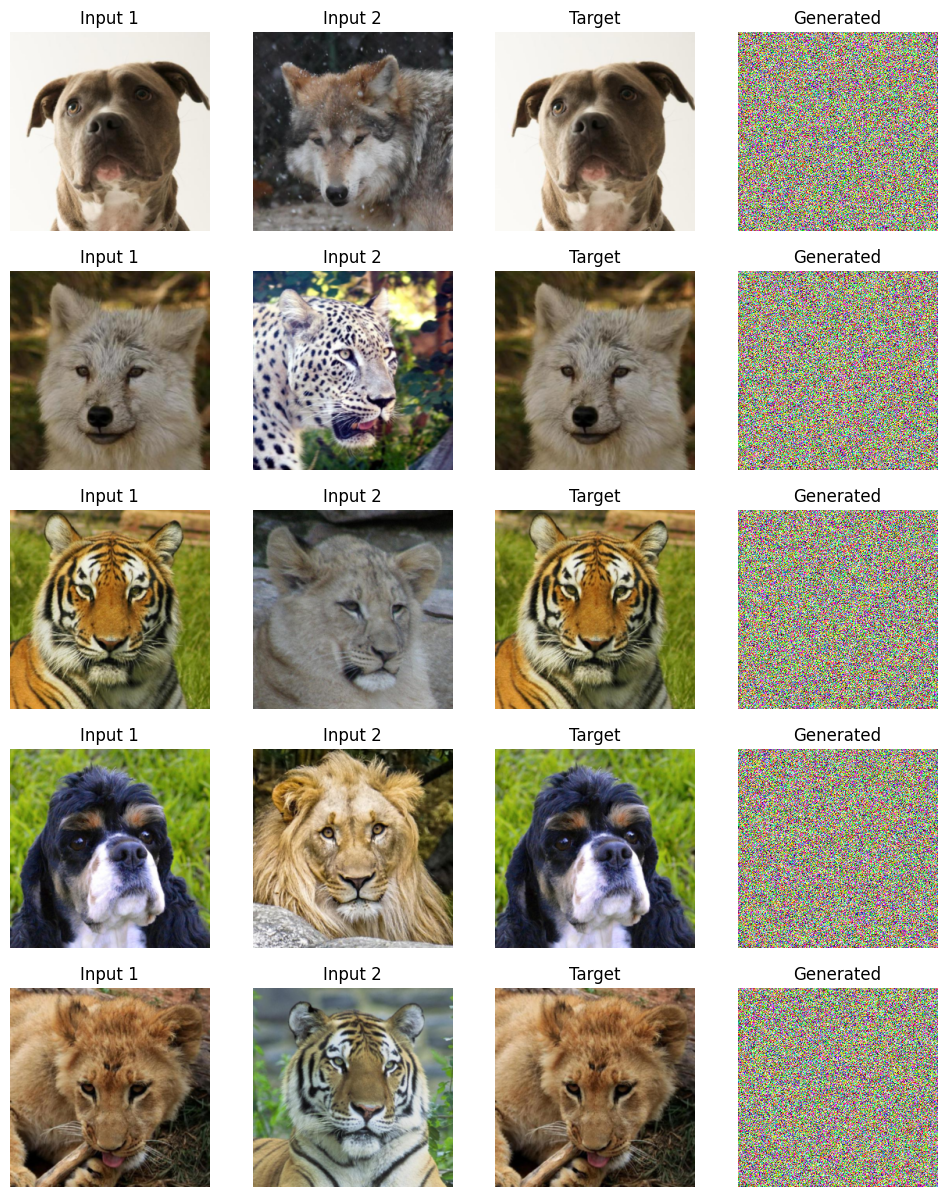

In [13]:
show_samples(model, fusion_loader, device=device, num_samples=5, num_inference_steps=500)